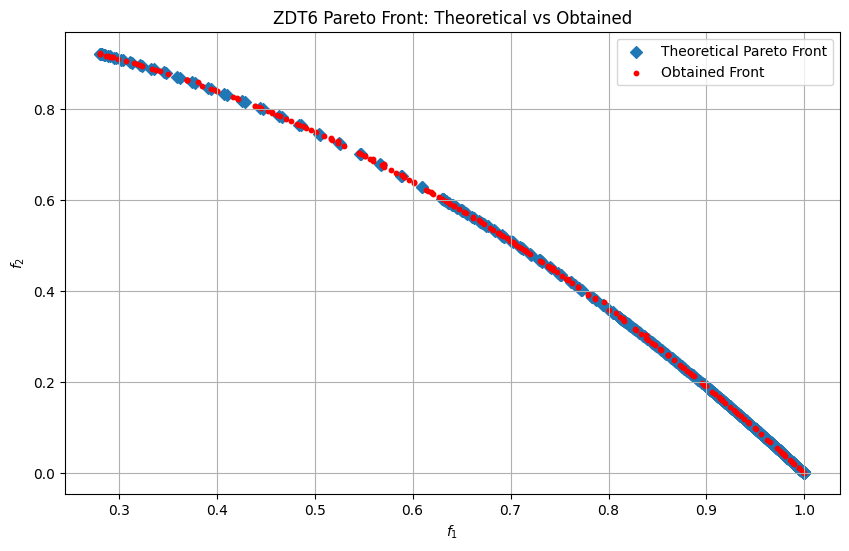

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pymoors import (
    Spea2,
    RandomSamplingFloat,
    GaussianMutation,
    ExponentialCrossover,
    CloseDuplicatesCleaner,
    Constraints
)
from pymoors.schemas import Population
from pymoors.typing import TwoDArray


def evaluate_zdt6(population: TwoDArray) -> TwoDArray:
    """
    Evaluate the ZDT6 objectives in a fully vectorized manner.
    """
    x1 = population[:, 0]
    n = population.shape[1]
    # g = 1 + (9/(n-1)) * sum(x[1:])
    g = 1 + (9 / (n - 1)) * np.sum(population[:, 1:], axis=1)
    # f1 = 1 - exp(-4*x1) * sin^6(6*pi*x1)
    f1 = 1 - np.exp(-4 * x1) * np.sin(6 * np.pi * x1) ** 6
    # h = 1 - (f1/g)^2
    h = 1 - (f1 / g) ** 2
    # f2 = g * h
    f2 = g * h
    return np.column_stack((f1, f2))


def zdt6_theoretical_front(num_points=1000):
    """
    Compute the theoretical Pareto front for ZDT6.
    """
    x1 = np.linspace(0, 1, num_points)
    f1 = 1 - np.exp(-4 * x1) * np.sin(6 * np.pi * x1) ** 6
    # when g = 1 → f2 = 1 - f1^2
    f2 = 1 - f1**2
    return f1, f2


# Set up the SPEA2 algorithm for ZDT6
algorithm = Spea2(
    sampler=RandomSamplingFloat(min=0, max=1),
    crossover=ExponentialCrossover(exponential_crossover_rate=0.75),
    mutation=GaussianMutation(gene_mutation_rate=0.1, sigma=0.01),
    fitness_fn=evaluate_zdt6,
    constraints_fn=Constraints(lower_bound=0.0, upper_bound=1.0),
    duplicates_cleaner=CloseDuplicatesCleaner(epsilon=1e-8),
    num_vars=30,
    population_size=200,
    num_offsprings=200,
    num_iterations=500,
    mutation_rate=0.1,
    crossover_rate=0.9,
    keep_infeasible=False,
    seed=42,
    verbose=False,
)

# Run SPEA2 on ZDT6
algorithm.run()

# Extract the obtained Pareto front
best: Population = algorithm.population.best_as_population
obtained_fitness = best.fitness
f1_found = obtained_fitness[:, 0]
f2_found = obtained_fitness[:, 1]

# Compute the theoretical front
f1_theo, f2_theo = zdt6_theoretical_front()

# Plot theoretical vs obtained
plt.figure(figsize=(10, 6))
plt.scatter(f1_theo, f2_theo, marker="D", label="Theoretical Pareto Front")
plt.scatter(f1_found, f2_found, c="r", marker="o", s=10, label="Obtained Front")
plt.xlabel("$f_1$")
plt.ylabel("$f_2$")
plt.title("ZDT6 Pareto Front: Theoretical vs Obtained")
plt.legend()
plt.grid(True)
plt.show()